# Arnold Schönberg - Korrespondenz Topics



Katharina Bleier, Machine Learning WS 2024/25

Import benötigter Module

In [3]:
import os
import csv
import xml.etree.ElementTree as ET
import pandas as pd
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize
from bertopic import BERTopic

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Präparation der Daten
(python code: e-Mail Martina Scholger an Katharina Bleier, 25.02.2025 in Kombination mit https://claude.ai/chat/c083bfb9-3470-4091-9181-ba9dcfceba00) - xml Dokumente sind Teil des Projektes https://www.schoenberg-ue.at und werden hier nicht veröffentlicht

In [57]:
# Define the folder containing the XML files
folder_path = "/Machine_Bleier"
output_csv = "/Machine_Bleier/letter_extract.csv"
namespace = {'tei': 'http://www.tei-c.org/ns/1.0'}

def extract_text(element):
    """
    Recursively extract text from an element,
    skipping the entire subtree of any <note> element.
    """
    # If this element is a <note>, skip it completely.
    if element.tag.endswith('note'):
        return ""

    # Start with the element's own text.
    text = element.text or ""

    # Process each child recursively.
    for child in element:
       text += extract_text(child)
       if child.tail:
            text += child.tail
    return text

def extract_letter_content_from_root(root):
    # (Using a dummy letter ID if not found)
    letter_id_elem = root.find('.//tei:idno', namespace)
    letter_id = letter_id_elem.text if letter_id_elem is not None else "No Letter ID Found"

    # Find all paragraph elements within body.
    paragraphs = root.findall('.//tei:body//tei:p', namespace)

    text_parts = []
    for p in paragraphs:
        paragraph_text = extract_text(p)
        # Normalize whitespace
        cleaned_text = ' '.join(paragraph_text.split())
        text_parts.append(cleaned_text)

    full_text = ' '.join(text_parts).strip()
    return letter_id, full_text

def process_xml_files(folder_path, output_csv):
    with open(output_csv, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Letter ID", "Full Text"])

        for filename in os.listdir(folder_path):
            if filename.endswith(".xml"):
                file_path = os.path.join(folder_path, filename)
                try:
                    tree = ET.parse(file_path)
                    root = tree.getroot()
                    letter_id, full_text = extract_letter_content_from_root(root)
                    writer.writerow([letter_id, full_text])
                except ET.ParseError as e:
                    print(f"Error parsing {filename}: {e}")

# Run the function
process_xml_files(folder_path, output_csv)

Splitting, Kleinschreibung, Stopwörter entfernen
(https://github.com/stopwords-iso/stopwords-de, Zugriff 01.03.2025)

In [75]:
df = pd.read_csv("/Machine_Bleier/letter_extract.csv")

#Erstelle Liste zum Abspeichern der Sätze
sentences = []

# Iteriere durch jede Zeile und splitte den Text
for index, row in df.iterrows():
    letter_id = row["Letter ID"]
    text = row["Full Text"]

    # Tokenisiere den Text in Sätze
    split_sentences = sent_tokenize(text)

    # Speichere jeden Satz zusammen mit der zughörigen Brief ID
    for sent in split_sentences:
        sentences.append({"Letter ID": letter_id, "Sentence": sent})

# Konvertiere die Liste in ein DataFrame
sentences_df = pd.DataFrame(sentences)

# Konvertiere den Inhalt der 'Sentence'-Spalte in Kleinbuchstaben
sentences_df["Sentence"] = sentences_df["Sentence"].str.lower()

# Lies Stopwords aus der txt-Datei, Erstelle Stopword-Liste
with open("/Machine_Bleier/stopwords_de.txt", "r") as file:
    stopwords = file.read().splitlines()
   
# Funktion zur Entfernung von Stopwords 
def remove_stopwords(sentence):
    words = sentence.split()  # Tokenize by whitespace
    filtered_words = [word for word in words if word not in stopwords]
    return " ".join(filtered_words)

# Wende Funktion auf Spalte 'Sentence' an
sentences_df["Sentence"] = sentences_df["Sentence"].apply(remove_stopwords)

sentences_df.to_csv("/Machine_Bleier/sentences.csv", index=False)

Datentyp "float" identifizieren und entsprechende Zeilen aus der csv-Datei entfernen
(code: https://chatgpt.com/share/67c5e3ed-8034-800c-b672-69f4dc4a76a3)

In [77]:
df = pd.read_csv("/Machine_Bleier/sentences.csv")

# Function to check if a value can be converted to a float
def is_float(value):
    try:
        float(value)  
        return True
    except ValueError:
        return False

# Identify rows where "Sentence" is a float
problematic_rows = df[df["Sentence"].apply(is_float)]

# Get the Letter IDs of problematic rows
problematic_ids = problematic_rows["Letter ID"].tolist()
print("Removed Letter IDs:", problematic_ids)

# Remove problematic rows
df_cleaned = df[~df["Sentence"].apply(is_float)]

# Save the cleaned DataFrame to a new CSV file
df_cleaned.to_csv("/Machine_Bleier/sentences.csv", index=False)

Removed Letter IDs: ['ASCC 1077', 'ASCC 114', 'ASCC 1142', 'ASCC 11565', 'ASCC 1189', 'ASCC 1189', 'ASCC 1217', 'ASCC 1217', 'ASCC 1217', 'ASCC 12372', 'ASCC 12375', 'ASCC 12387', 'ASCC 12389', 'ASCC 12389', 'ASCC 12397', 'ASCC 13042', 'ASCC 1506', 'ASCC 1512', 'ASCC 1512', 'ASCC 1512', 'ASCC 1512', 'ASCC 1512', 'ASCC 1512', 'ASCC 1512', 'ASCC 1571', 'ASCC 1571', 'ASCC 1571', 'ASCC 16826', 'ASCC 16826', 'ASCC 16828', 'ASCC 16832', 'ASCC 17350', 'ASCC 17363', 'ASCC 17368', 'ASCC 17523', 'ASCC 17546', 'ASCC 17557', 'ASCC 17562', 'ASCC 17566', 'ASCC 17571', 'ASCC 17581', 'ASCC 17581', 'ASCC 17625', 'ASCC 17625', 'ASCC 17633', 'ASCC 17633', 'ASCC 17633', 'ASCC 17633', 'ASCC 17644', 'ASCC 17658', 'ASCC 17669', 'ASCC 17672', 'ASCC 17681', 'ASCC 17682', 'ASCC 17694', 'ASCC 17707', 'ASCC 17711', 'ASCC 17717', 'ASCC 17717', 'ASCC 17732', 'ASCC 17748', 'ASCC 1798', 'ASCC 19686', 'ASCC 19876', 'ASCC 19876', 'ASCC 19877', 'ASCC 19879', 'ASCC 20232', 'ASCC 20326', 'ASCC 20701', 'ASCC 20728', 'ASCC 

Die Daten werden aus der vorbereiteten csv-Datei in ein pandas DataFrame geladen, eine Vorschau angezeigt. Anschließend wird der Text aus der Spalte 'text' in eine Liste konvertiert.

In [4]:
df = pd.read_table('/Machine_Bleier/sentences.csv', encoding='utf-8', sep=',', header=0, names=['id', 'text'])
print(df)
dftexts = df.text.to_list()

              id                                               text
0      ASCC 1005  anbei brief münchener hofkapellmeisters röhr a...
1      ASCC 1005                           empfehle anliegen gerne.
2      ASCC 1005                gewiss, können für opportun halten.
3      ASCC 1005                          bitte rücksendung briefe.
4      ASCC 1011     für durchfüh rung verkaufes völkerbundanleihe.
...          ...                                                ...
15323   ASCC 996                                                ii.
15324   ASCC 996  sehen, freigabe für amerika praktischen wert hat.
15325   ASCC 996  zwecke müssen ad 1) a) probeaufstellung über b...
15326   ASCC 996  ad 2) möchte bitten, beziehungen ernster natur...
15327   ASCC 996  übrigen bereit, un verhandlungen aufzunehmen w...

[15328 rows x 2 columns]


Das BERTopic-Modell in der mehrsprachigen Variante wird der Variable zugewiesen, verbose dokumentiert den Status während der Ausführung, Topics werden generiert.

In [5]:
topic_model = BERTopic(verbose=True, language="multilingual")
topics, probs = topic_model.fit_transform(dftexts)

2025-03-04 10:29:04,234 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/479 [00:00<?, ?it/s]

2025-03-04 10:31:48,648 - BERTopic - Embedding - Completed ✓
2025-03-04 10:31:48,650 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-04 10:32:16,142 - BERTopic - Dimensionality - Completed ✓
2025-03-04 10:32:16,155 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-04 10:32:17,091 - BERTopic - Cluster - Completed ✓
2025-03-04 10:32:17,108 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-04 10:32:17,572 - BERTopic - Representation - Completed ✓


Speichern des Modells 

In [9]:
topic_model.save("/Machine_Bleier/sentences.mm")

2025-03-04 10:38:00,148 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Laden des Modells

In [11]:
topic_model = BERTopic.load("/Machine_Bleier/sentences.mm")

Anzeige der identifizierten Topics

In [13]:
topic_info=topic_model.get_topic_info()
print(topic_info)

     Topic  Count                                               Name  \
0       -1   6793                             -1_für_ist_über_werden   
1        0    237               0_vertrag_vertrages_unseres_verträge   
2        1    225                           1_ihnen_gehts_damit_wahr   
3        2    221  2_orchester_kammersymphonie_kammersinfonie_orc...   
4        3    161                3_berlin_berliner_frankfurt_adresse   
..     ...    ...                                                ...   
228    227     10                227_geld_ehre_verausgabtes_tauschen   
229    228     10                     228_irrtum_falsch_unrecht_irrt   
230    229     10     229_imitieren_orchesterstil_gleichen_verfahren   
231    230     10               230_200_100fache_bedenkt_verfügbaren   
232    231     10       231_gewähren_abnehmern_eingelau_wievielfache   

                                        Representation  \
0    [für, ist, über, werden, werke, wäre, sind, ha...   
1    [vertrag, vert

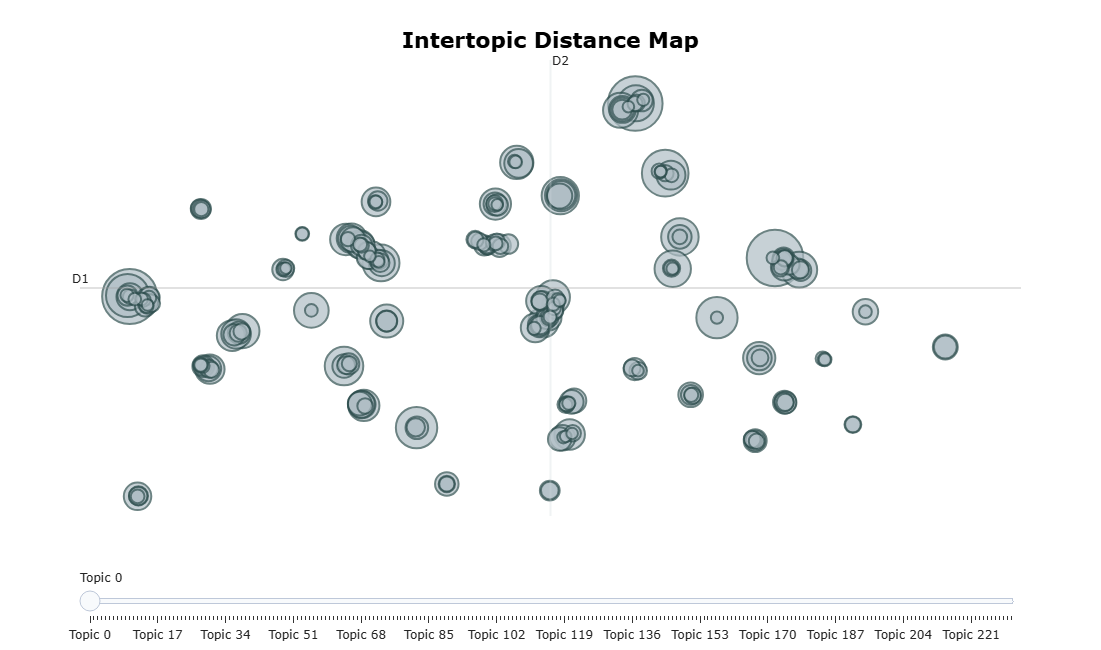

In [17]:
topic_model.visualize_topics()

Ausgewählte Topics im Detail

In [19]:
topic_model.get_topic(-1)

[('für', 0.003840942603799929),
 ('ist', 0.00336384731054102),
 ('über', 0.003346172375573746),
 ('werden', 0.003325740480894274),
 ('werke', 0.0032652887386022842),
 ('wäre', 0.003100100363108775),
 ('sind', 0.0030734953366595283),
 ('haben', 0.003030922536856629),
 ('lassen', 0.0030042981073491208),
 ('können', 0.00293225352384817)]

In [21]:
topic_model.get_topic(0)

[('vertrag', 0.04432121062248826),
 ('vertrages', 0.02930720123688256),
 ('unseres', 0.017735910589761067),
 ('verträge', 0.014489863756310374),
 ('vertrags', 0.013072064025481556),
 ('verträgen', 0.010105681627666426),
 ('punkt', 0.009595313639920139),
 ('unseren', 0.009548575601919922),
 ('unserem', 0.008178753833548621),
 ('verlängerung', 0.008150408578400305)]

In [23]:
topic_model.get_topic(2)

[('orchester', 0.05217982209862466),
 ('kammersymphonie', 0.02914852858892109),
 ('kammersinfonie', 0.021127797406252823),
 ('orchesterlieder', 0.015746585820212582),
 ('kammer', 0.014118657069699761),
 ('dichtung', 0.011415215205575098),
 ('symphonie', 0.01086482408913292),
 ('variationen', 0.010497723880141722),
 ('proben', 0.009890206958375728),
 ('aufführen', 0.0098410859351105)]

In [37]:
print(topic_info[11:13])

    Topic  Count                                               Name  \
11     10    101  10_material_materiale_auskorrigierte_ausschlie...   
12     11     98               11_drucken_druckerei_gedruckt_papier   

                                       Representation  \
11  [material, materiale, auskorrigierte, ausschli...   
12  [drucken, druckerei, gedruckt, papier, druckle...   

                                  Representative_Docs  
11  [komplette aufführungs-materiale liegen, sorgf...  
12     [bitte drucken mich!!!, druckerei., drucken ?]  


Reduktion der Topics

In [45]:
topic_model.reduce_topics(dftexts, nr_topics=30)

2025-03-04 11:12:11,866 - BERTopic - Topic reduction - Reducing number of topics
2025-03-04 11:12:11,869 - BERTopic - Topic reduction - Reduced number of topics from 30 to 30


In [47]:
topic_info=topic_model.get_topic_info()
print(topic_info)

    Topic  Count                                               Name  \
0      -1   6793                              -1_für_ist_über_bitte   
1       0   2993                               0_bitte_brief_ii_für   
2       1    782            1_orchester_quartett_harmonielehre_oper   
3       2    639            2_manuskript_drucken_partitur_schreiben   
4       3    630              3_vertrag_amerika_vertrages_vorschlag   
5       4    448                          4_nicht_hätte_leid_fehler   
6       5    332                  5_berlin_paris_deutschen_berliner   
7       6    323                            6_konto_betrag_mark_500   
8       7    302                 7_letzten_woche_warten_rechtzeitig   
9       8    280                                      8_20_30_ds_27   
10      9    194                        9_direktor_dr_hertzka_herrn   
11     10    187             10_pelleas_material_partitur_materiale   
12     11    185            11_arbeit_werk_schwierigkeiten_arbeiten   
13    

Merge Topic 12 und 17

In [53]:
topic_model.merge_topics(dftexts, topics_to_merge=[12, 17])
print(topic_info)

    Topic  Count                                               Name  \
0      -1   6793                              -1_für_ist_über_bitte   
1       0   2993                               0_bitte_brief_ii_für   
2       1    782            1_orchester_quartett_harmonielehre_oper   
3       2    639            2_manuskript_drucken_partitur_schreiben   
4       3    630              3_vertrag_amerika_vertrages_vorschlag   
5       4    448                          4_nicht_hätte_leid_fehler   
6       5    332                  5_berlin_paris_deutschen_berliner   
7       6    323                            6_konto_betrag_mark_500   
8       7    302                 7_letzten_woche_warten_rechtzeitig   
9       8    280                                      8_20_30_ds_27   
10      9    194                        9_direktor_dr_hertzka_herrn   
11     10    187             10_pelleas_material_partitur_materiale   
12     11    185            11_arbeit_werk_schwierigkeiten_arbeiten   
13    

In [55]:
topic_info=topic_model.get_topic_info()
print(topic_info)

    Topic  Count                                             Name  \
0      -1   6793                            -1_für_ist_über_bitte   
1       0   2993                             0_bitte_brief_ii_für   
2       1    782          1_orchester_quartett_harmonielehre_oper   
3       2    639          2_manuskript_partitur_drucken_schreiben   
4       3    630            3_vertrag_amerika_vertrages_vorschlag   
5       4    448                        4_nicht_hätte_leid_fehler   
6       5    332                5_berlin_paris_deutschen_berliner   
7       6    323                          6_konto_betrag_mark_500   
8       7    311                7_pelleas_material_1932_september   
9       8    302               8_letzten_woche_warten_rechtzeitig   
10      9    281           9_aufführung_aufführungen_kritiken_für   
11     10    280                                   10_20_30_ds_27   
12     11    238                          11_new_arbeit_york_werk   
13     12    194                  

Visualisierung als Heatmap

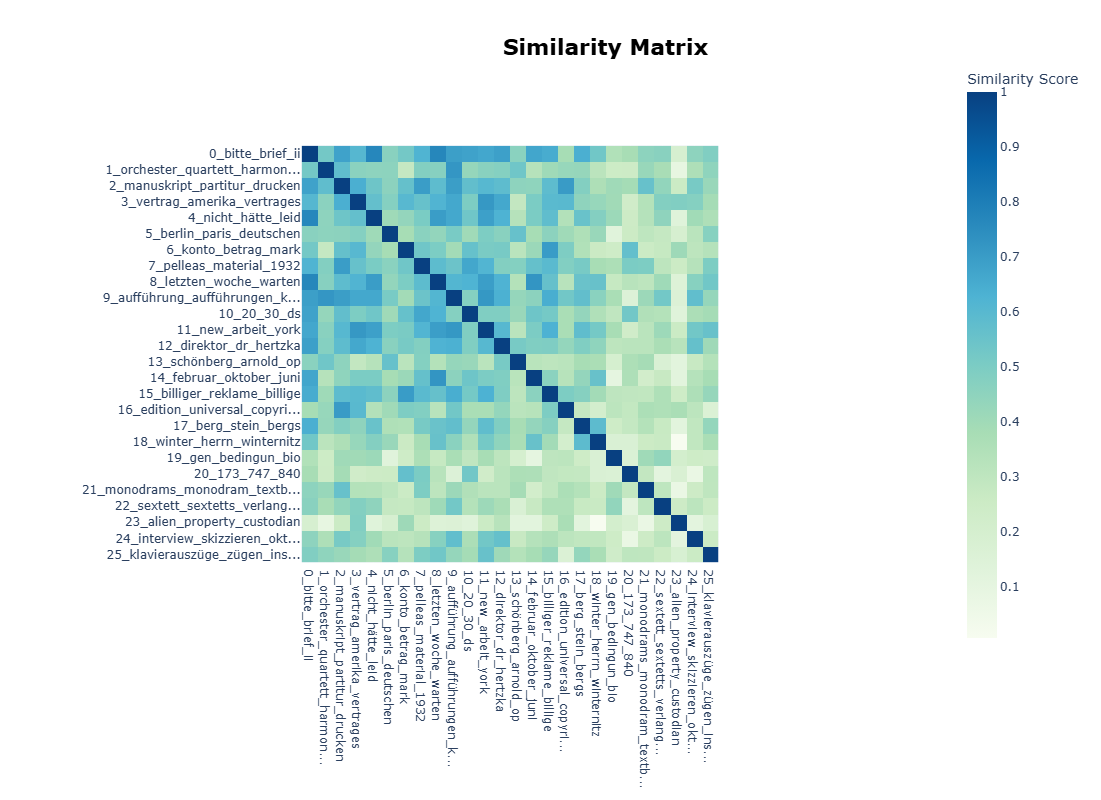

In [57]:
topic_model.visualize_heatmap()